In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/maheshsadupalli/ml-test-loader-original-data-csv/ML_test_loader_original_data.csv


# Neural Network-Based Flow Field Compression — Offline Training & Evaluation
- **Base Model**: 4 → 64 → 64 → 32 → 4 (6,692 parameters)
- **Large Model**: 4 → 128 → 128 → 64 → 4 (25,476 parameters)

In [5]:
"""Unified Training Utilities for Neural Network-Based Flow Field Compression"""

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pyarrow.csv as pv
from torcheval.metrics import PeakSignalNoiseRatio
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import time
import os
import json


class FlowFieldDataset(Dataset):
    """Spatio-temporal flow field dataset with min-max normalization to [0, 1]."""

    def __init__(self, filepath):
        print(f"[Data] Loading dataset from {filepath}")
        read_options = pv.ReadOptions(
            column_names=['x', 'y', 'z', 't', 'Vx', 'Vy', 'Pressure', 'TKE']
        )
        table = pv.read_csv(filepath, read_options=read_options)
        data = table.to_pandas().values
        self.inputs = data[:, :4].astype(np.float32)
        self.targets = data[:, 4:].astype(np.float32)
        print("[Data] Applying min-max normalization to [0, 1] range")
        self.input_min = self.inputs.min(axis=0)
        self.input_max = self.inputs.max(axis=0)
        self.input_range = self.input_max - self.input_min
        self.input_range[self.input_range == 0] = 1.0
        self.inputs = (self.inputs - self.input_min) / self.input_range
        self.target_min = self.targets.min(axis=0)
        self.target_max = self.targets.max(axis=0)
        self.target_range = self.target_max - self.target_min
        self.target_range[self.target_range == 0] = 1.0
        self.targets = (self.targets - self.target_min) / self.target_range
        print(f"[Data] Loaded {len(self):,} samples | Input: {self.inputs.shape} | Target: {self.targets.shape}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(self.targets[idx])

    def denormalize_input(self, normalized):
        if isinstance(normalized, torch.Tensor):
            normalized = normalized.cpu().numpy()
        return normalized * self.input_range + self.input_min

    def denormalize_target(self, normalized):
        if isinstance(normalized, torch.Tensor):
            normalized = normalized.cpu().numpy()
        return normalized * self.target_range + self.target_min


class BaseCompressor(nn.Module):
    """Base compression network: 4 -> 64 -> 64 -> 32 -> 4"""

    def __init__(self):
        super(BaseCompressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.model(x)


class LargeCompressor(nn.Module):
    """Large compression network: 4 -> 128 -> 128 -> 64 -> 4"""

    def __init__(self):
        super(LargeCompressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.model(x)


def compute_psnr_ssim(predictions, targets, device):
    """Compute PSNR and SSIM for regression data using per-point comparison (kernel_size=1)."""
    predictions = predictions.to(device)
    targets = targets.to(device)

    psnr_metric = PeakSignalNoiseRatio().to(device)
    psnr_metric.update(predictions, targets)
    psnr = psnr_metric.compute().item()

    pred_ssim = predictions.view(-1, 1, 1, predictions.shape[1])
    target_ssim = targets.view(-1, 1, 1, targets.shape[1])
    pred_ssim = pred_ssim.permute(1, 2, 0, 3)
    target_ssim = target_ssim.permute(1, 2, 0, 3)

    ssim_metric = StructuralSimilarityIndexMeasure(
        gaussian_kernel=False, kernel_size=1
    ).to(device)
    ssim_metric.update(pred_ssim, target_ssim)
    ssim = ssim_metric.compute().item()

    return psnr, ssim


def compute_relative_error(predictions, targets):
    """Compute relative L2 norm error as a percentage."""
    target_norm = torch.norm(targets)
    error = torch.norm(predictions - targets)
    return (error / target_norm * 100).item()


def train_model(model, train_loader, dataset, device, epochs, model_name, output_dir):
    """Train a compression model and save weights, normalization parameters, and metrics."""
    os.makedirs(output_dir, exist_ok=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    metrics = {'loss': [], 'psnr': [], 'ssim': [], 'relative_error': [], 'time_per_epoch': []}
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n[Train] Model: {model_name}")
    print(f"[Train] Samples: {len(dataset):,} | Epochs: {epochs} | Device: {device}")
    print(f"[Train] Parameters: {total_params:,} | Size: {total_params * 4 / 1024:.2f} KB\n")
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        epoch_loss = 0.0
        all_predictions = []
        all_targets = []
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            all_predictions.append(outputs.detach())
            all_targets.append(targets)
        epoch_loss /= len(train_loader)
        metrics['loss'].append(epoch_loss)
        all_predictions = torch.cat(all_predictions, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        psnr, ssim = compute_psnr_ssim(all_predictions, all_targets, device)
        rel_error = compute_relative_error(all_predictions, all_targets)
        metrics['psnr'].append(psnr)
        metrics['ssim'].append(ssim)
        metrics['relative_error'].append(rel_error)
        epoch_time = time.time() - epoch_start
        metrics['time_per_epoch'].append(epoch_time)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:>3}/{epochs}: Loss={epoch_loss:.6f}, "
                  f"PSNR={psnr:.2f} dB, SSIM={ssim:.4f}, "
                  f"Rel. Error={rel_error:.2f}%, Time={epoch_time:.2f}s")
    model_path = os.path.join(output_dir, f'{model_name}_minmax.pth')
    torch.save(model.state_dict(), model_path)
    print(f"\n[Train] Model saved: {model_path}")
    norm_params = {
        'input_min': dataset.input_min.tolist(),
        'input_max': dataset.input_max.tolist(),
        'input_range': dataset.input_range.tolist(),
        'target_min': dataset.target_min.tolist(),
        'target_max': dataset.target_max.tolist(),
        'target_range': dataset.target_range.tolist()
    }
    norm_path = os.path.join(output_dir, f'{model_name}_normalization.json')
    with open(norm_path, 'w') as f:
        json.dump(norm_params, f, indent=2)
    print(f"[Train] Normalization parameters saved: {norm_path}")
    print(f"\n[Train] Training completed for {model_name}")
    print(f"  Final Loss:           {metrics['loss'][-1]:.6f}")
    print(f"  Final PSNR:           {metrics['psnr'][-1]:.2f} dB")
    print(f"  Final SSIM:           {metrics['ssim'][-1]:.4f}")
    print(f"  Final Relative Error: {metrics['relative_error'][-1]:.2f}%")
    print(f"  PSNR Improvement:     {metrics['psnr'][0]:.2f} \u2192 {metrics['psnr'][-1]:.2f} dB "
          f"({metrics['psnr'][-1]-metrics['psnr'][0]:+.2f} dB)\n")
    return metrics


def export_metrics_csv(metrics, output_path):
    """Export training metrics history to CSV."""
    df = pd.DataFrame(metrics)
    df['epoch'] = range(1, len(df) + 1)
    df = df[['epoch', 'loss', 'psnr', 'ssim', 'relative_error', 'time_per_epoch']]
    df.to_csv(output_path, index=False)
    print(f"[Export] Metrics saved: {output_path}")

In [6]:
DATA_FILE = "/kaggle/input/datasets/maheshsadupalli/ml-test-loader-original-data-csv/ML_test_loader_original_data.csv"
EPOCHS = 150
BATCH_SIZE = 512
TIMESTEP = 0.0396

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Config] Device: {device}")

dataset = FlowFieldDataset(DATA_FILE)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

[Config] Device: cuda
[Data] Loading dataset from /kaggle/input/datasets/maheshsadupalli/ml-test-loader-original-data-csv/ML_test_loader_original_data.csv
[Data] Applying min-max normalization to [0, 1] range
[Data] Loaded 7,919,100 samples | Input: (7919100, 4) | Target: (7919100, 4)


---
## 1. Base Model (64-64-32) — Training

In [7]:
BASE_OUTPUT_DIR = "/kaggle/working/results/base_model_offline"

base_model = BaseCompressor().to(device)

base_metrics = train_model(
    model=base_model,
    train_loader=train_loader,
    dataset=dataset,
    device=device,
    epochs=EPOCHS,
    model_name='base_model',
    output_dir=BASE_OUTPUT_DIR
)

export_metrics_csv(base_metrics, f"{BASE_OUTPUT_DIR}/base_model_metrics.csv")


[Train] Model: base_model
[Train] Samples: 7,919,100 | Epochs: 150 | Device: cuda
[Train] Parameters: 6,692 | Size: 26.14 KB

  Epoch   1/150: Loss=0.005344, PSNR=22.72 dB, SSIM=0.8981, Rel. Error=13.08%, Time=77.33s
  Epoch  10/150: Loss=0.001468, PSNR=28.33 dB, SSIM=0.9218, Rel. Error=6.85%, Time=79.35s
  Epoch  20/150: Loss=0.001199, PSNR=29.21 dB, SSIM=0.9223, Rel. Error=6.19%, Time=77.36s
  Epoch  30/150: Loss=0.001086, PSNR=29.64 dB, SSIM=0.9247, Rel. Error=5.90%, Time=77.63s
  Epoch  40/150: Loss=0.001017, PSNR=29.93 dB, SSIM=0.9266, Rel. Error=5.70%, Time=77.74s
  Epoch  50/150: Loss=0.000973, PSNR=30.12 dB, SSIM=0.9270, Rel. Error=5.58%, Time=78.28s
  Epoch  60/150: Loss=0.000939, PSNR=30.27 dB, SSIM=0.9278, Rel. Error=5.48%, Time=77.86s
  Epoch  70/150: Loss=0.000913, PSNR=30.40 dB, SSIM=0.9291, Rel. Error=5.40%, Time=76.91s
  Epoch  80/150: Loss=0.000890, PSNR=30.51 dB, SSIM=0.9311, Rel. Error=5.34%, Time=77.17s
  Epoch  90/150: Loss=0.000874, PSNR=30.59 dB, SSIM=0.9317, Re

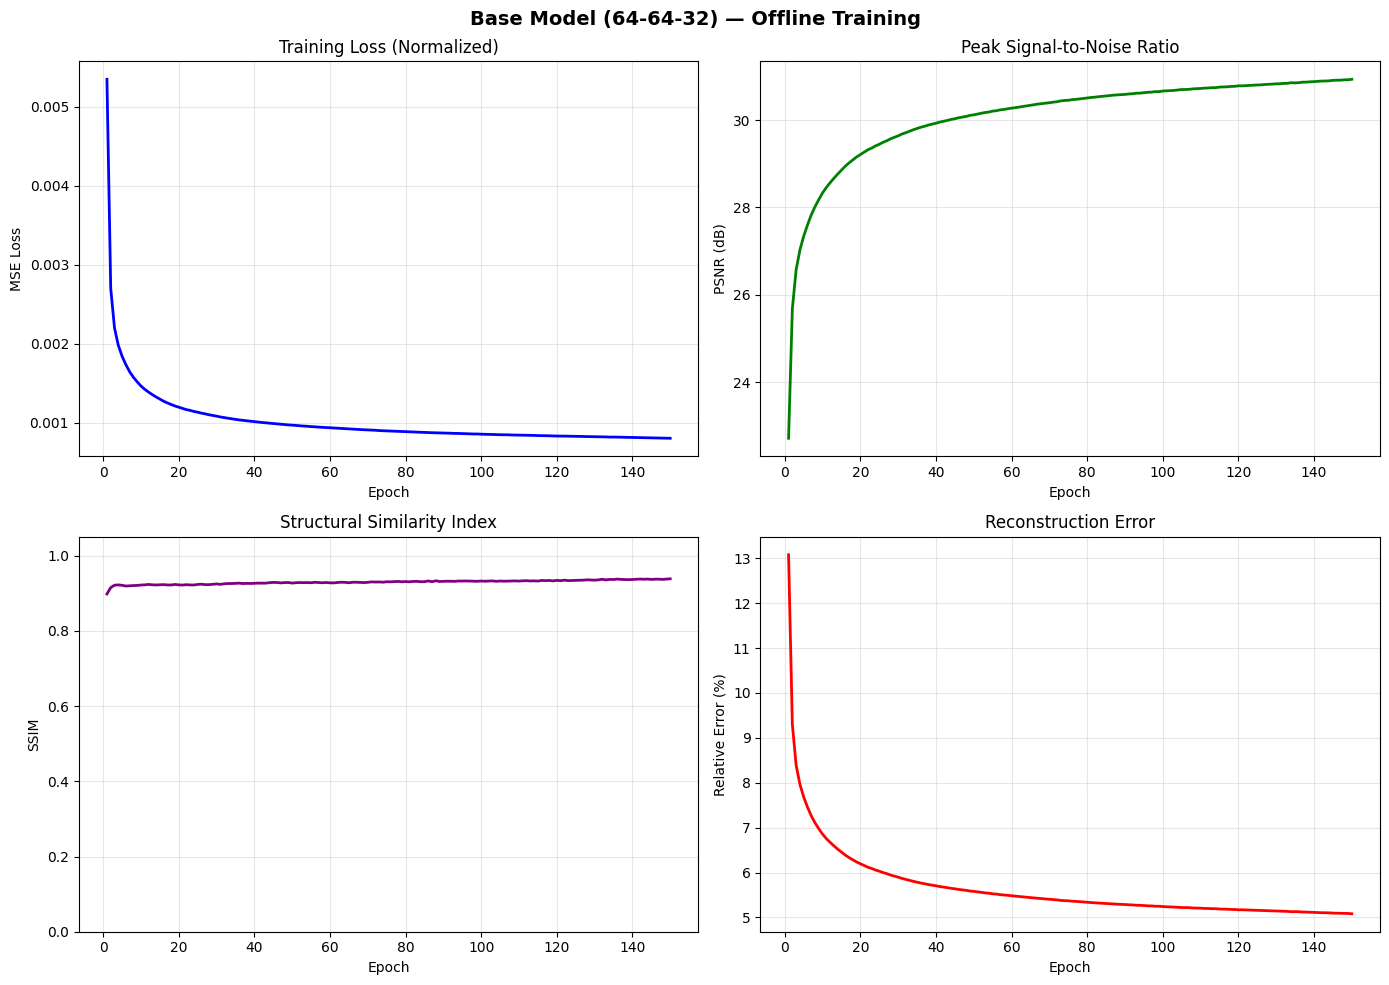

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs_range = range(1, len(base_metrics['loss']) + 1)

axes[0, 0].plot(epochs_range, base_metrics['loss'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Loss (Normalized)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(epochs_range, base_metrics['psnr'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('Peak Signal-to-Noise Ratio')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(epochs_range, base_metrics['ssim'], 'purple', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].set_title('Structural Similarity Index')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

axes[1, 1].plot(epochs_range, base_metrics['relative_error'], 'r-', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Relative Error (%)')
axes[1, 1].set_title('Reconstruction Error')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Base Model (64-64-32) — Offline Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{BASE_OUTPUT_DIR}/base_model_training_progress.png", dpi=300, bbox_inches='tight')
plt.show()

## 1.1 Base Model — Evaluation & Visualization

In [9]:
BASE_VIZ_DIR = "/kaggle/working/results/base_model_offline_viz"
os.makedirs(BASE_VIZ_DIR, exist_ok=True)

base_model.load_state_dict(torch.load(f"{BASE_OUTPUT_DIR}/base_model_minmax.pth", map_location=device))
base_model.eval()

print(f"[Eval] Base model: {sum(p.numel() for p in base_model.parameters()):,} parameters")

all_inputs = torch.from_numpy(dataset.inputs).to(device)
with torch.no_grad():
    base_predictions = base_model(all_inputs).cpu()

all_targets = torch.from_numpy(dataset.targets)

base_psnr, base_ssim = compute_psnr_ssim(base_predictions, all_targets, device)
print(f"[Eval] PSNR: {base_psnr:.2f} dB | SSIM: {base_ssim:.4f}")

base_pred_denorm = dataset.denormalize_target(base_predictions.numpy())
targets_denorm = dataset.denormalize_target(all_targets.numpy())
coords_denorm = dataset.denormalize_input(dataset.inputs)

timestep_mask = np.abs(coords_denorm[:, 3] - TIMESTEP) < 1e-6
x = coords_denorm[timestep_mask, 0]
y = coords_denorm[timestep_mask, 1]
base_pred_t = base_pred_denorm[timestep_mask]
target_t = targets_denorm[timestep_mask]
base_errors_t = np.abs(target_t - base_pred_t)

print(f"[Eval] Visualizing {len(x):,} points at timestep {TIMESTEP}")

[Eval] Base model: 6,692 parameters
[Eval] PSNR: 30.90 dB | SSIM: 0.9201
[Eval] Visualizing 26,397 points at timestep 0.0396


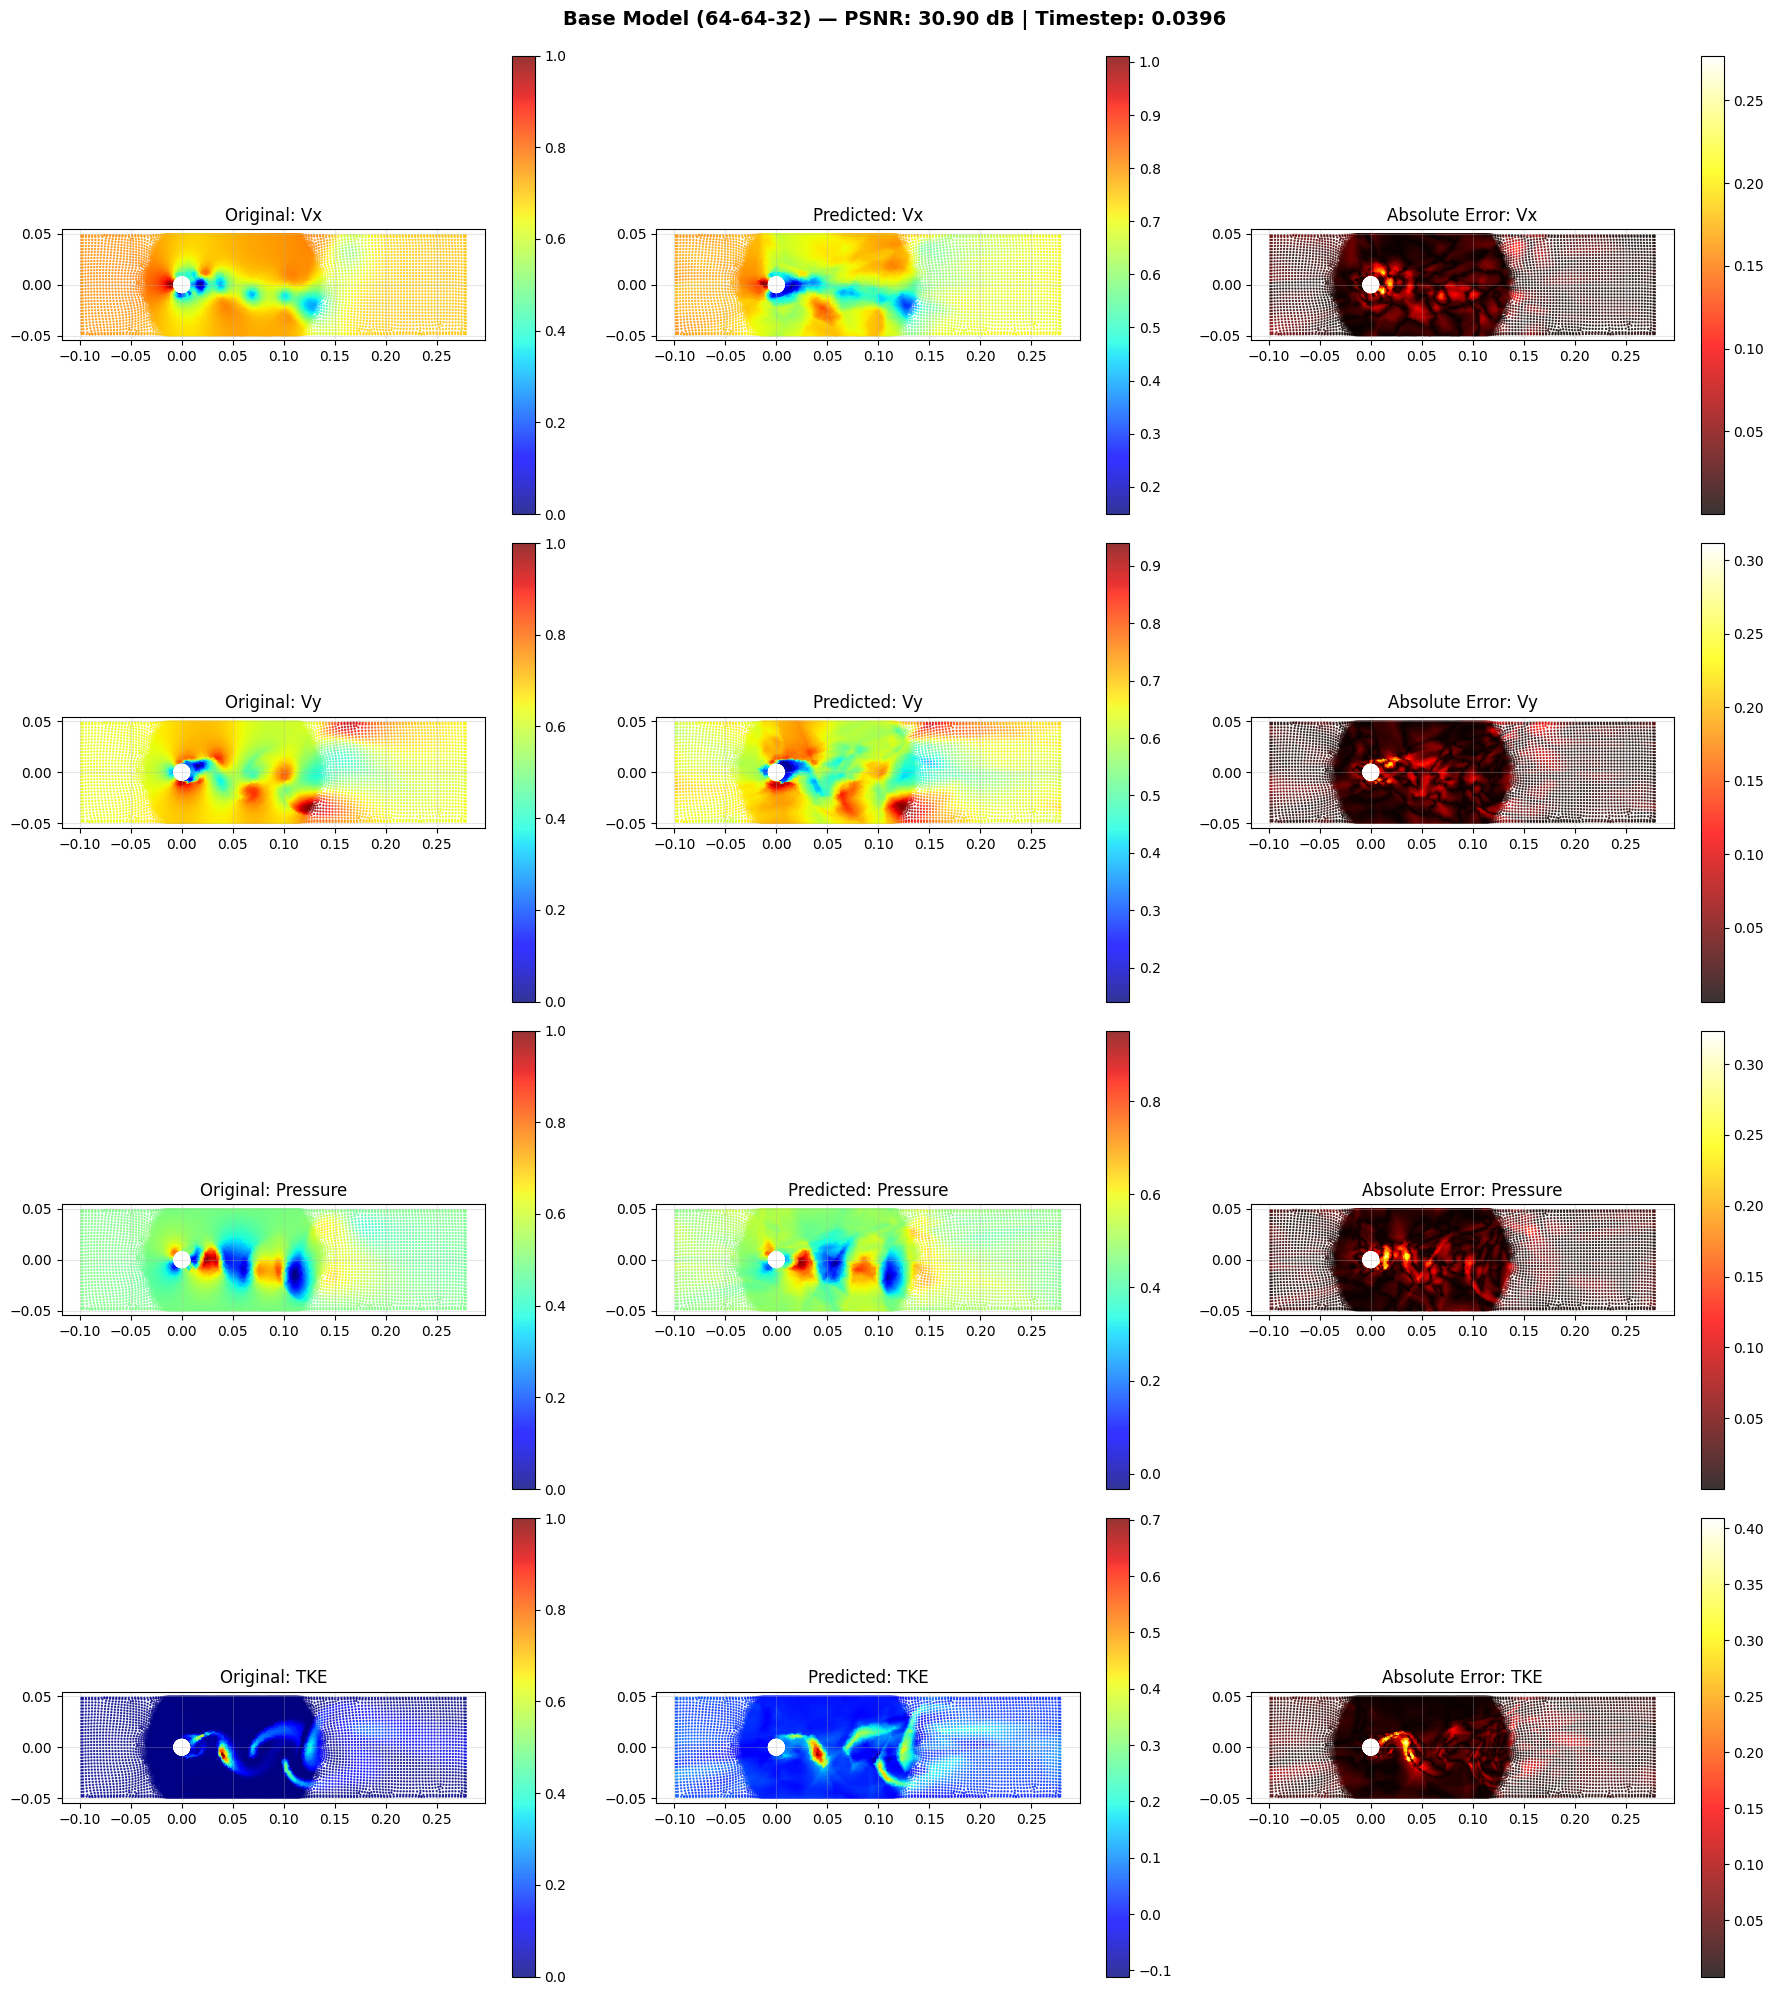

[Eval] Base model evaluation completed


In [10]:
feature_names = ['Vx', 'Vy', 'Pressure', 'TKE']
feature_indices = [0, 1, 2, 3]

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for row, (idx, name) in enumerate(zip(feature_indices, feature_names)):
    original = target_t[:, idx]
    predicted = base_pred_t[:, idx]
    error = base_errors_t[:, idx]

    sc1 = axes[row, 0].scatter(x, y, c=original, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 0].set_title(f'Original: {name}')
    axes[row, 0].set_aspect('equal')
    axes[row, 0].grid(True, alpha=0.3)
    plt.colorbar(sc1, ax=axes[row, 0])

    sc2 = axes[row, 1].scatter(x, y, c=predicted, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 1].set_title(f'Predicted: {name}')
    axes[row, 1].set_aspect('equal')
    axes[row, 1].grid(True, alpha=0.3)
    plt.colorbar(sc2, ax=axes[row, 1])

    sc3 = axes[row, 2].scatter(x, y, c=error, cmap='hot', s=0.5, alpha=0.8)
    axes[row, 2].set_title(f'Absolute Error: {name}')
    axes[row, 2].set_aspect('equal')
    axes[row, 2].grid(True, alpha=0.3)
    plt.colorbar(sc3, ax=axes[row, 2])

plt.suptitle(f'Base Model (64-64-32) — PSNR: {base_psnr:.2f} dB | Timestep: {TIMESTEP}',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f"{BASE_VIZ_DIR}/base_flow_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

base_eval_metrics = {
    'model': 'base_model_minmax.pth',
    'architecture': '4-64-64-32-4',
    'parameters': sum(p.numel() for p in base_model.parameters()),
    'psnr_db': float(base_psnr),
    'ssim': float(base_ssim)
}

with open(f"{BASE_VIZ_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(base_eval_metrics, f, indent=2)

print("[Eval] Base model evaluation completed")

---
## 2. Large Model (128-128-64) — Training

In [11]:
LARGE_OUTPUT_DIR = "/kaggle/working/results/large_model_offline"

large_model = LargeCompressor().to(device)

large_metrics = train_model(
    model=large_model,
    train_loader=train_loader,
    dataset=dataset,
    device=device,
    epochs=EPOCHS,
    model_name='large_model',
    output_dir=LARGE_OUTPUT_DIR
)

export_metrics_csv(large_metrics, f"{LARGE_OUTPUT_DIR}/large_model_metrics.csv")


[Train] Model: large_model
[Train] Samples: 7,919,100 | Epochs: 150 | Device: cuda
[Train] Parameters: 25,668 | Size: 100.27 KB

  Epoch   1/150: Loss=0.004463, PSNR=23.50 dB, SSIM=0.9022, Rel. Error=11.95%, Time=78.87s
  Epoch  10/150: Loss=0.000772, PSNR=31.13 dB, SSIM=0.9587, Rel. Error=4.97%, Time=79.91s
  Epoch  20/150: Loss=0.000558, PSNR=32.53 dB, SSIM=0.9614, Rel. Error=4.23%, Time=79.54s
  Epoch  30/150: Loss=0.000478, PSNR=33.21 dB, SSIM=0.9646, Rel. Error=3.91%, Time=79.59s
  Epoch  40/150: Loss=0.000429, PSNR=33.68 dB, SSIM=0.9665, Rel. Error=3.71%, Time=79.66s
  Epoch  50/150: Loss=0.000398, PSNR=34.00 dB, SSIM=0.9697, Rel. Error=3.57%, Time=79.48s
  Epoch  60/150: Loss=0.000376, PSNR=34.25 dB, SSIM=0.9712, Rel. Error=3.47%, Time=78.86s
  Epoch  70/150: Loss=0.000357, PSNR=34.47 dB, SSIM=0.9720, Rel. Error=3.38%, Time=79.07s
  Epoch  80/150: Loss=0.000343, PSNR=34.65 dB, SSIM=0.9752, Rel. Error=3.31%, Time=78.75s
  Epoch  90/150: Loss=0.000330, PSNR=34.82 dB, SSIM=0.9737,

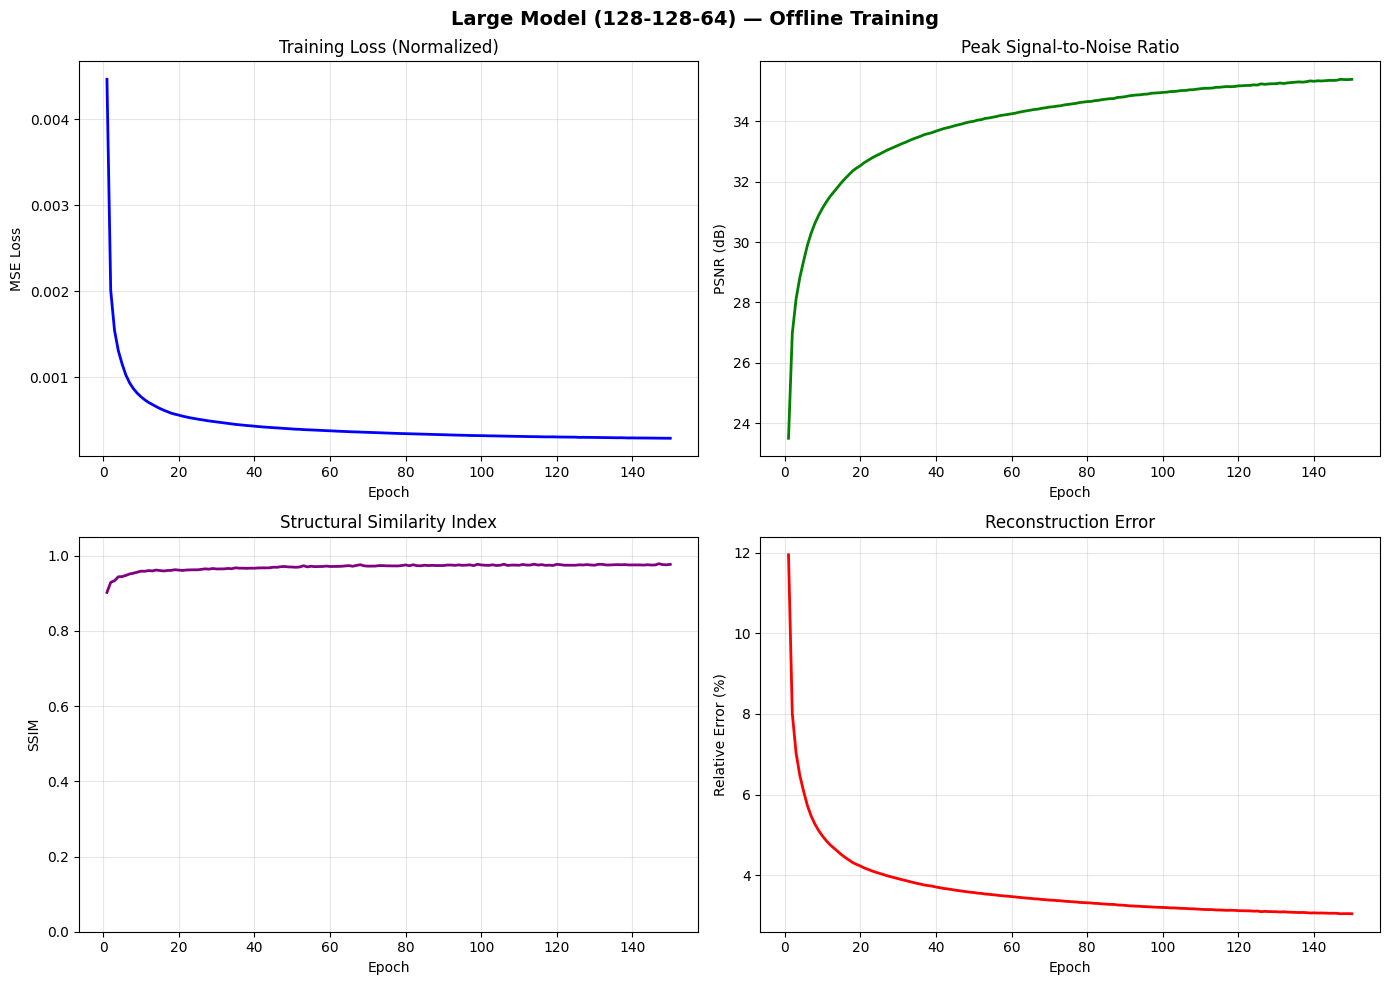

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs_range = range(1, len(large_metrics['loss']) + 1)

axes[0, 0].plot(epochs_range, large_metrics['loss'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Loss (Normalized)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(epochs_range, large_metrics['psnr'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('Peak Signal-to-Noise Ratio')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(epochs_range, large_metrics['ssim'], 'purple', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].set_title('Structural Similarity Index')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

axes[1, 1].plot(epochs_range, large_metrics['relative_error'], 'r-', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Relative Error (%)')
axes[1, 1].set_title('Reconstruction Error')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Large Model (128-128-64) — Offline Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{LARGE_OUTPUT_DIR}/large_model_training_progress.png", dpi=300, bbox_inches='tight')
plt.show()

## 2.1 Large Model — Evaluation & Visualization

In [13]:
LARGE_VIZ_DIR = "/kaggle/working/results/large_model_offline_viz"
os.makedirs(LARGE_VIZ_DIR, exist_ok=True)

large_model.load_state_dict(torch.load(f"{LARGE_OUTPUT_DIR}/large_model_minmax.pth", map_location=device))
large_model.eval()

print(f"[Eval] Large model: {sum(p.numel() for p in large_model.parameters()):,} parameters")

with torch.no_grad():
    large_predictions = large_model(all_inputs).cpu()

large_psnr, large_ssim = compute_psnr_ssim(large_predictions, all_targets, device)
print(f"[Eval] PSNR: {large_psnr:.2f} dB | SSIM: {large_ssim:.4f}")

large_pred_denorm = dataset.denormalize_target(large_predictions.numpy())

large_pred_t = large_pred_denorm[timestep_mask]
large_errors_t = np.abs(target_t - large_pred_t)

print(f"[Eval] Visualizing {len(x):,} points at timestep {TIMESTEP}")

[Eval] Large model: 25,668 parameters
[Eval] PSNR: 35.59 dB | SSIM: 0.9797
[Eval] Visualizing 26,397 points at timestep 0.0396


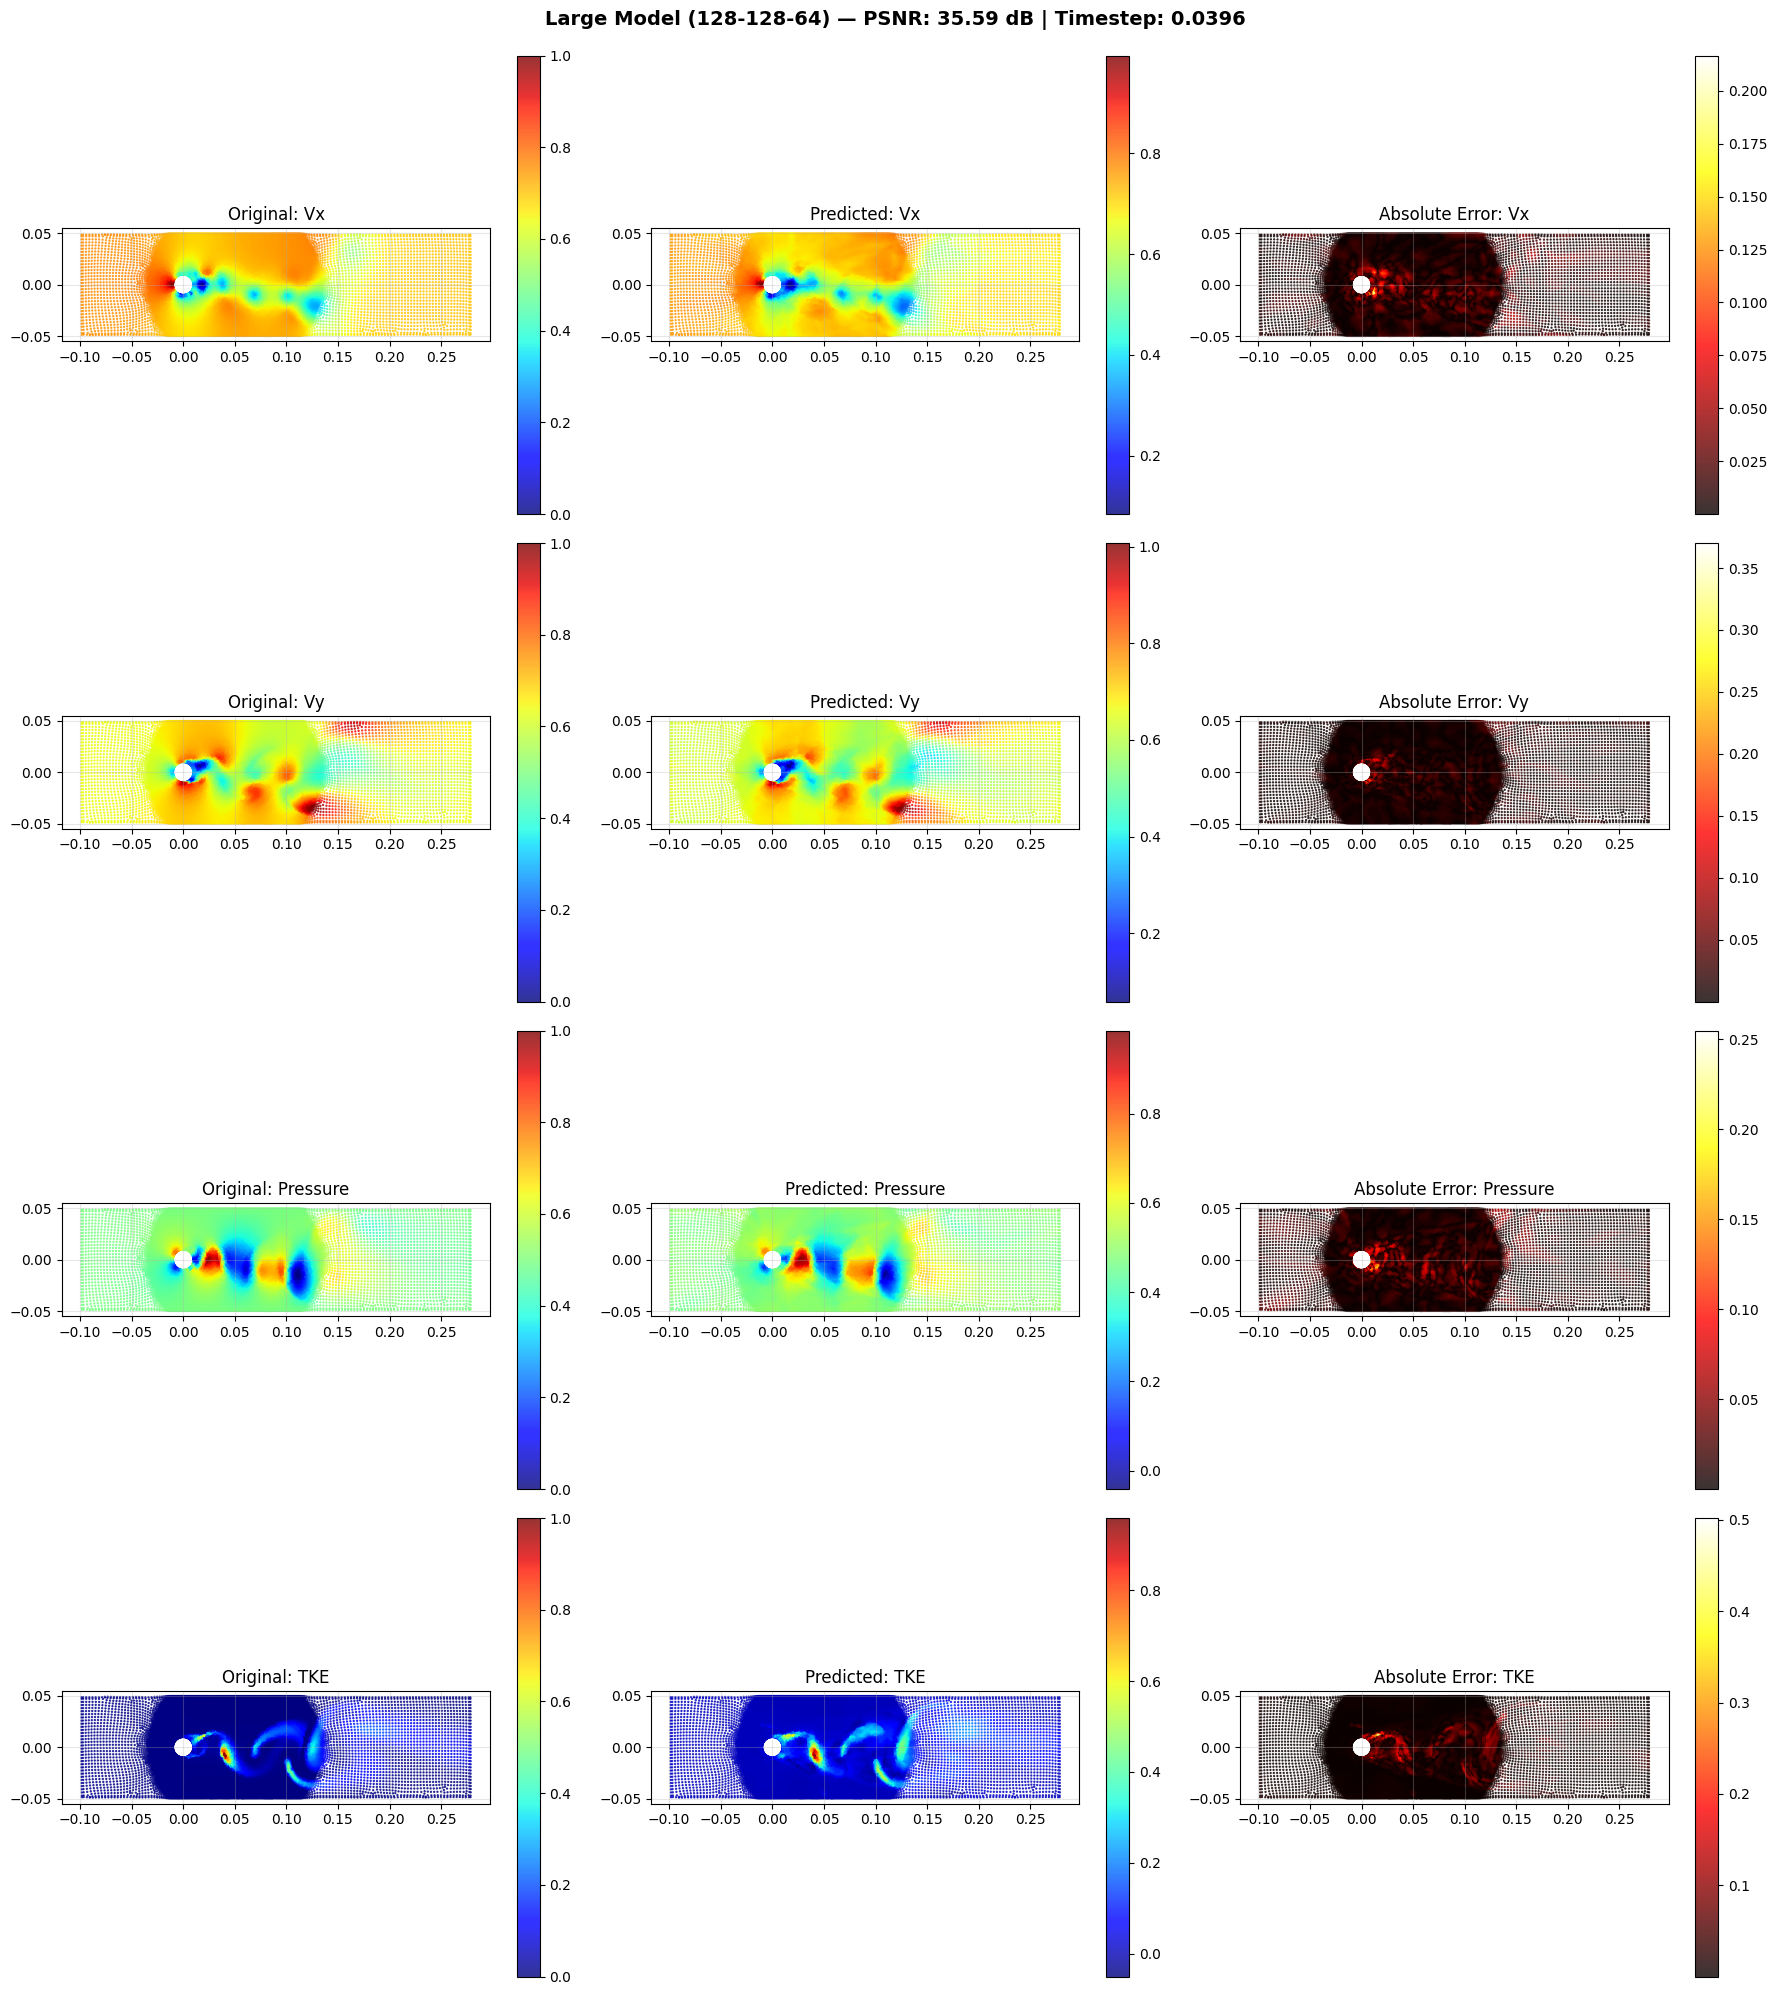

[Eval] Large model evaluation completed


In [14]:
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for row, (idx, name) in enumerate(zip(feature_indices, feature_names)):
    original = target_t[:, idx]
    predicted = large_pred_t[:, idx]
    error = large_errors_t[:, idx]

    sc1 = axes[row, 0].scatter(x, y, c=original, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 0].set_title(f'Original: {name}')
    axes[row, 0].set_aspect('equal')
    axes[row, 0].grid(True, alpha=0.3)
    plt.colorbar(sc1, ax=axes[row, 0])

    sc2 = axes[row, 1].scatter(x, y, c=predicted, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 1].set_title(f'Predicted: {name}')
    axes[row, 1].set_aspect('equal')
    axes[row, 1].grid(True, alpha=0.3)
    plt.colorbar(sc2, ax=axes[row, 1])

    sc3 = axes[row, 2].scatter(x, y, c=error, cmap='hot', s=0.5, alpha=0.8)
    axes[row, 2].set_title(f'Absolute Error: {name}')
    axes[row, 2].set_aspect('equal')
    axes[row, 2].grid(True, alpha=0.3)
    plt.colorbar(sc3, ax=axes[row, 2])

plt.suptitle(f'Large Model (128-128-64) — PSNR: {large_psnr:.2f} dB | Timestep: {TIMESTEP}',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f"{LARGE_VIZ_DIR}/large_flow_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

large_eval_metrics = {
    'model': 'large_model_minmax.pth',
    'architecture': '4-128-128-64-4',
    'parameters': sum(p.numel() for p in large_model.parameters()),
    'psnr_db': float(large_psnr),
    'ssim': float(large_ssim)
}

with open(f"{LARGE_VIZ_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(large_eval_metrics, f, indent=2)

print("[Eval] Large model evaluation completed")

---
## 3. Model Comparison

In [15]:
print("=" * 65)
print("MODEL COMPARISON SUMMARY")
print("=" * 65)
print(f"{'Metric':<25} {'Base (64-64-32)':>18} {'Large (128-128-64)':>20}")
print("-" * 65)
print(f"{'Parameters':<25} {sum(p.numel() for p in base_model.parameters()):>18,} {sum(p.numel() for p in large_model.parameters()):>20,}")
print(f"{'Model Size (KB)':<25} {sum(p.numel() for p in base_model.parameters()) * 4 / 1024:>18.2f} {sum(p.numel() for p in large_model.parameters()) * 4 / 1024:>20.2f}")
print(f"{'Final Train Loss':<25} {base_metrics['loss'][-1]:>18.6f} {large_metrics['loss'][-1]:>20.6f}")
print(f"{'Final Train PSNR (dB)':<25} {base_metrics['psnr'][-1]:>18.2f} {large_metrics['psnr'][-1]:>20.2f}")
print(f"{'Final Train SSIM':<25} {base_metrics['ssim'][-1]:>18.4f} {large_metrics['ssim'][-1]:>20.4f}")
print(f"{'Final Rel. Error (%)':<25} {base_metrics['relative_error'][-1]:>18.2f} {large_metrics['relative_error'][-1]:>20.2f}")
print(f"{'Eval PSNR (dB)':<25} {base_psnr:>18.2f} {large_psnr:>20.2f}")
print(f"{'Eval SSIM':<25} {base_ssim:>18.4f} {large_ssim:>20.4f}")
print("=" * 65)

MODEL COMPARISON SUMMARY
Metric                       Base (64-64-32)   Large (128-128-64)
-----------------------------------------------------------------
Parameters                             6,692               25,668
Model Size (KB)                        26.14               100.27
Final Train Loss                    0.000807             0.000289
Final Train PSNR (dB)                  30.93                35.39
Final Train SSIM                      0.9384               0.9768
Final Rel. Error (%)                    5.08                 3.04
Eval PSNR (dB)                         30.90                35.59
Eval SSIM                             0.9201               0.9797
